# Kaggle case: 
https://www.kaggle.com/miell534/gamespot-article-classification

La base de dades que procesare en aquesta entrega conte els articles (trobats en www.gamespot.com) sobre els millors i pitjors jocs fins l'any 2019. Aquests articles son reviews del joc i li otorgan la nota. 

## Atributs:
Aquesta base te 12 atributs dels quals 4 son numerics la resta esta composta per 2 links, 3 categorics i 3 strings. Previ a cap analisis dels atributs descarto utilitzar els links per generar els meus models.

### Atributs numerics:
 - ID: va del 0 al 1183 i cada joc en te un diferent no te altre utilitat que no sigui per identificar i iteratr les diferents files de la base de dades.
 - score: determina la puntuacio que un joc te, aquesta te un domini entre 1.6 i 10 pero com es pot observar en el historigrama presentat mes a baix hi ha un absencia de mostres desde el 4,9 fins al 8,3. Aixo prove del fet que la base de dades nomes te els jocs amb les puntuacions mes altes i baixes, aixi que els que es troben en el mitj no tenen entrades. 
 - Polarity i Subjectivity: son els dos atributs numerics restants i son valors generats amb TextBlob (llibreria externa de tractament de textos) a partir de l'article del joc en questio. Aquests estan el la base de dades amb el proposit de predir la score, en el codi sobministrat per el creador de la base de dades s'explica breument com s'extreuen.
 
### Altres atributs:
 - name: el nom del joc.
 - tagline: el titol de l'article del joc.
 - boxart: link a la imatge de la portada del joc (gran part dels links no funcionen)
 - system: determina la plataforma en la que el joc va ser disponible primer. Aquest atribut esta compost per 723 consoles diferents aixi que es bastant inutilitzable a l'hora de fer models.
 - link: el link a l'article, el creador de la base de dades l'utilitza per extreuren l'article utilitzant BeautifulSoup.
 - classifier: atribut que prove de la score del joc, si aquest es troba en el grup amb score alta el valor es "pos" i respectivament amb els de score baixa i "neg". Aquest es molt util per entrenar models de clasificacio, com ara un model NaiveBayes. 
 - article i filtered article: l'article raw amb totes les paraules d'aquest i l'article filtrat mitjancant "stopwords" un recurs utilitzat per filtrar les paraules mes utilitzades i fer la execucio molt mes rapida.
 
### Atribut objectiu:

Utilitzare el score com a atribut onjectiu ja que aquest es el que hem sembla mes relevant, mes a baix faig la observacio que el score i el classifier poden ser directament igualats aixi que en algun model l'objectiu es el classifier.

## Recursos externs utilitzats:

In [1]:
#Per a calculs i gestio de arrays:
import math
import numpy as np

#Gestio de la base de dades:
import pandas as pd

#Preprocessing:
import sklearn 
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer

#Visualitzacio:
import seaborn as sns;
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

#Estructura entrenament, test...  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#Models Sklearn:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

#Models TextBlob:
from textblob import TextBlob
from textblob import classifiers

## Base de dades:
Mitjancant pandas extraiem les dades del fitxer csv i les posem en un dataset per a la seva facil manipulacio, despres d'aixo comprovo que s'hagi importat correctament la base de dades.

In [2]:
# Funció per a llegir dades en format csv:
def load_dataset(path):
    ds = pd.read_csv(path, header=0, delimiter=',')
    return ds

pd.set_option('display.float_format', lambda x: '%.2f' % x)
dataset = load_dataset('gamespot_game_reviews.csv')
print("El dataset te (entrades, atributs): ", dataset.shape[:])

El dataset te (entrades, atributs):  (1184, 12)


## Tractament dels atributs:
Primer creem un dataset nou i comprovem les seves dimencions:

In [3]:
df = pd.DataFrame(dataset)
print(df.shape[0])

1184


He observat que hi ha una entrada que esta corompuda ja que al accedir a aquesta l'article es inexistent i dona valors erronis tant en subjectivity com polarity aixi que la treiem i ens asegurem de que no n'hi hagin mes.

In [4]:
for i in range(df.shape[0]):
    if (isinstance(df['article'][i], float)):
        df = df.drop([df.index[i]])
        
print(df.shape[0])

1183


Tambe he detectat que en el proces de canviar de char a bool l'atribut classifier que aquests estan ordenats de 8 en 8 intercalant positius i negatius, aixo no hem causara cap problema ja que sempre avans de entrenar els models selecciono els elements de manera aleatoria, pero mha semblat curios.

In [5]:
Y = [0 if x == 'pos' else 1 for x in df['classifier']]
print(Y[:16])

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]


Canviar el atribut system de categorit a numeric (strings a int) per cada consola diferent:

In [6]:
df['system'] = df['system'].astype(str)
label_encoder = sklearn.preprocessing.LabelEncoder() 
df['system'] = label_encoder.fit_transform(df['system'])

### PCA

In [7]:
X = df.values[:, [10, 11]]

pca = PCA()
pca.fit(X)
pca_data = pca.transform(X)

In [8]:
labels = ['PC1']
#df = pd.DataFrame(pca_data[:,0], columns=labels)
df.insert(0, "PC1", pca_data[:,0], True)
df.iloc[:,1]

0          0
1          1
2          2
3          3
4          4
        ... 
1179    1179
1180    1180
1181    1181
1182    1182
1183    1183
Name: Unnamed: 0, Length: 1183, dtype: int64

## VIsualitzacio dels atributs:
En aquest pas podre observar quins atributs hem poden ser de mes utilitat a l'hora de fer els models:

En quant als atributs numerics tant la destribucio de la polarity i subjectivity no ens dona gaire informacio pero en el cas de la score podem veure un problema que ens impedira aplicar varios tipus de models ja que com he mencionat abans les dades l'aquest atribut estan dividides en 2 grups molt establerts.

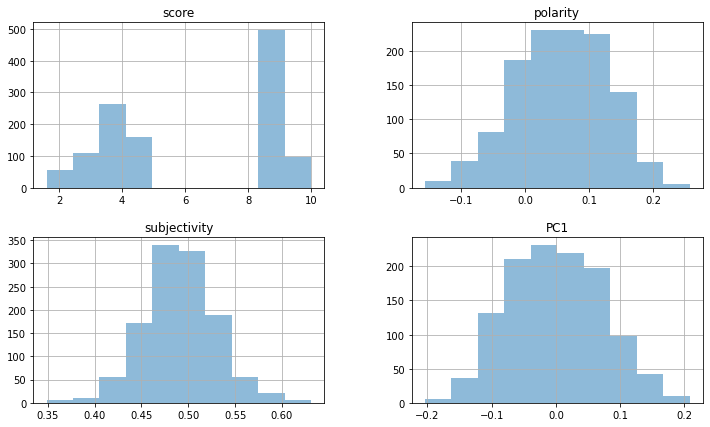

In [9]:
df[['score', 'polarity','subjectivity','PC1']].hist(figsize=(12,7), alpha=0.5)
plt.show()

### Atributs numerics i score:
Com he mencionat abans tant polarity com subjectivity son dos atributs generats mitjancant TextBlob amb l'objectiu de construir un model eficient per predir la score. 

Tot i aixo a causa de l'ausencia d'entrades amb score intermitja models de regresio lineal no seran molt efectius, per tant tindrem que utilitzar models logistics ja que les dades estan agrupades en 2 molt clarament.

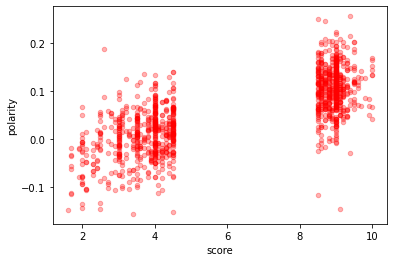

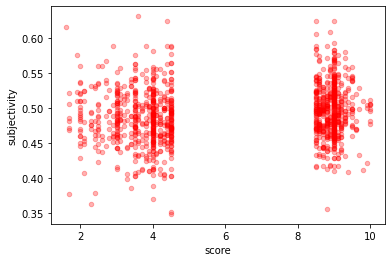

In [10]:
df.plot(kind='scatter',x='score',y='polarity',color='red', alpha=0.3)
plt.show()

df.plot(kind='scatter',x='score',y='subjectivity',color='red', alpha=0.3)
plt.show()

Ta li com era de esperat la score i el classifier estan directament relacionats i amb un model logistic sera facil extreure un 100% de precisio ja que la ausencia de scores intermitjes ens deixa una frontera molt clara entre la clase positiva i negativa.

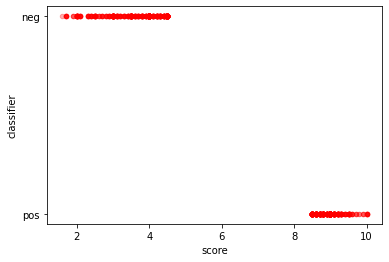

In [11]:
df.plot(kind='scatter',x='score',y='classifier', color='red', alpha=0.3)
plt.show()

### Correlacio:
Per ultim faig una matriu de correlacio per acabar de confirmar la informacio extreta de les grafiques, aqui confirmo que el valor numeric mes util sera la polarity ja que te la correlacio amb la score mes aceptable de la matriu.

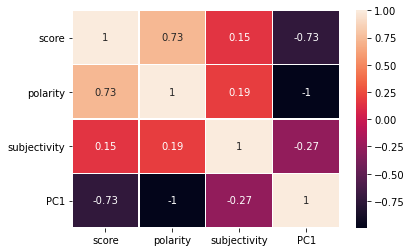

In [12]:
correlacio = df[['score', 'polarity','subjectivity','PC1']].corr()
plt.figure()
ax = sns.heatmap(correlacio, annot=True, linewidths=.5)

## LinearRegression
No tinc moltes espectatives en aquest model ja que com ja he mencionat les dades no son molt adequades i com ja he comentat avans el tall abrupte en l'atribut SCORE fara aquest tipus de aprenentatge molt poc eficient.

In [13]:
df.drop(["PC1"], axis=1, inplace=True)
X = df.values[:, [10, 11]]
x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.7)

In [14]:
regr = LinearRegression()
regr.fit(x_train, y_train)
print (regr.score(x_val, y_val))

0.5027713870778483


Entreno amb els atributs obtinguts amb el PCA, no espero molt ja que no tenia gaires.

In [15]:
X = pca_data
x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.7)

In [16]:
regr = LinearRegression()
regr.fit(x_train, y_train)
print (regr.score(x_val, y_val))

0.48214619662312586


## LogisticRegression

Com he comentat les en les grafiques la relacio entre polarity / subjectivity i la score del videojoc es bastant bona per analitzarla amb un clasificador logistic.

In [17]:
X = df.values[:, [10, 11]]
x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.7)

In [18]:
logr = LogisticRegression()
logr.fit(x_train, y_train)
print (logr.score(x_val, y_val))

0.847887323943662


Utilitzant la score per predir el clasifier, com es de esperar en aquest model obtindrem una score altisima.

In [19]:
X = df.values[:, [2]]
x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.7)

In [20]:
logr = LogisticRegression()
logr.fit(x_train, y_train)
print (logr.score(x_val, y_val))

1.0


## NaiveBayesClassifier
Tenint en compte les limitacions de la base de dades he arribat a la conclusio que un  clasificador de naive bayes que mitjancant l'alticle (filtrat i no filtrat) i el tagline prediu si la valoracio es positiva o negativa.

Genero els conjunts train i validation, en aquest model no necesitem els valors de y aixi que els obiarem, despres entreno i verifico que el model s'ha generat correctament:

In [21]:
print("Utilitzant filtered article")
X = df.values[:,[9,7]] #Amb filtered article
x_train, x_val, y_train, y_val = train_test_split(X, X, train_size=0.7)

gs_classifier = classifiers.NaiveBayesClassifier(x_train)
gs_classifier.show_informative_features(3)
print("Acuracy: ", str(round((gs_classifier.accuracy(x_val)*100), 2)))


print("Utilitzant article")
X = df.values[:,[8,7]] #Amb article
x_train, x_val, y_train, y_val = train_test_split(X, X, train_size=0.7)

gs_classifier = classifiers.NaiveBayesClassifier(x_train)
gs_classifier.show_informative_features(3)
print("Acuracy: ", str(round((gs_classifier.accuracy(x_val)*100), 2)))


print("Utilitzant tagline")
X = df.values[:,[3,7]] #Amb tagline
x_train, x_val, y_train, y_val = train_test_split(X, X, train_size=0.7)

gs_classifier = classifiers.NaiveBayesClassifier(x_train)
gs_classifier.show_informative_features(3)
print("Acuracy: ", str(round((gs_classifier.accuracy(x_val)*100), 2)))

Utilitzant filtered article
Most Informative Features
           contains(5.1) = True              pos : neg    =      6.4 : 1.0
      contains(GameSpot) = True              pos : neg    =      5.0 : 1.0
  contains(shoot-'em-up) = True              neg : pos    =      4.9 : 1.0
Acuracy:  67.04
Utilitzant article
Most Informative Features
   contains(outstanding) = True              pos : neg    =     19.0 : 1.0
        contains(enable) = True              pos : neg    =     18.8 : 1.0
    contains(seamlessly) = True              pos : neg    =     18.8 : 1.0
Acuracy:  76.9
Utilitzant tagline
Most Informative Features
          contains(best) = True              pos : neg    =     14.9 : 1.0
         contains(world) = True              pos : neg    =      9.0 : 1.0
   contains(multiplayer) = True              pos : neg    =      8.6 : 1.0
Acuracy:  87.04


## Model final i Crosvalidation:
Per fer el crosvalidation he triat el model que anteriorment m'ha donat millors resultats la regresio logistica utilitzant subjectivity i polarity per a predir la score del videojoc en questio.

Faig un crosvalidation amb els resultats del PCA per verificar les deduccions anteriors.

In [22]:
def logCrosvalLoop():
    X = df.values[:, [10, 11]]
    x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.7)

    logr = LogisticRegression()
    logr.fit(x_train, y_train)

    scores = cross_val_score(logr, x_train, y_train, cv=10)

    scores = pd.Series(scores)
    return scores.mean();

In [23]:
def logCrosvalLoopPCA():
    X = pca_data
    x_train, x_val, y_train, y_val = train_test_split(X, Y, train_size=0.7)

    logr = LogisticRegression()
    logr.fit(x_train, y_train)

    scores = cross_val_score(logr, x_train, y_train, cv=10)

    scores = pd.Series(scores)
    return scores.mean();

In [24]:
totalMean = 0
iterations = 1000

for i in range(iterations):
    totalMean += logCrosvalLoop()
    
totalMean = totalMean/iterations
    
print('Cross-Validation Accuracy Scores with', iterations, 'iterations:') 
print('   mean: ', str(round((totalMean*100), 2)))


totalMean = 0
for i in range(iterations):
    totalMean += logCrosvalLoopPCA()
    
totalMean = totalMean/iterations
    
print('Cross-Validation Accuracy Scores (PCA) with', iterations, 'iterations:') 
print('   mean: ', str(round((totalMean*100), 2)))

Cross-Validation Accuracy Scores with 1000 iterations:
   mean:  85.54
Cross-Validation Accuracy Scores (PCA) with 1000 iterations:
   mean:  85.53
